Device: cpu
Loaded model from checkpoints/unet.pth


/tmp/ipython-input-842732516.py:179: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=='cuda'))


Epoch 1/2:   0%|          | 0/98 [00:00<?, ?it/s]

/tmp/ipython-input-842732516.py:193: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 1/2 | Train Loss=0.4545 | Val Loss=0.2844 | mIoU=0.5012
Saved model to checkpoints/unet.pth


Epoch 2/2:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 2/2 | Train Loss=0.4162 | Val Loss=0.2682 | mIoU=0.5070
Saved model to checkpoints/unet.pth
Loaded model from checkpoints/unet.pth


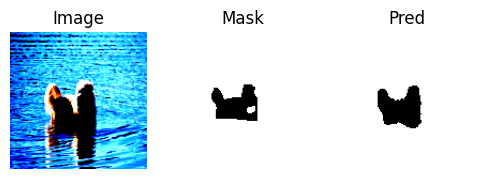

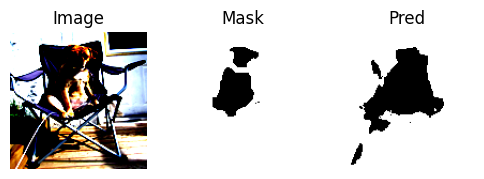

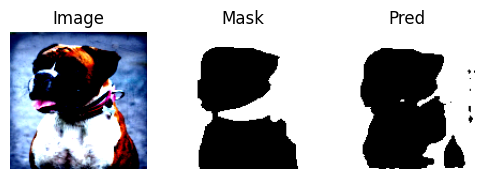

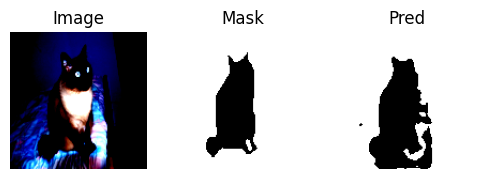

In [ ]:
import os, random, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

plt.rcParams['figure.figsize'] = (6,4)

# Lovasz loss (nếu có)
try:
    from lovasz_losses import lovasz_softmax
    HAVE_LOV = True
except:
    HAVE_LOV = False

# Focal loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super().__init__()
        self.gamma = gamma
        self.weight = weight
    def forward(self, input, target):
        logpt = -F.cross_entropy(input, target, weight=self.weight, reduction='none')
        pt = torch.exp(logpt)
        loss = -((1-pt)**self.gamma) * logpt
        return loss.mean()

# Seed + device
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)


IMG_SIZE = 128
n_classes = 3  # multi-class example

tfm_img = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
tfm_mask = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE), transforms.InterpolationMode.NEAREST),
    transforms.PILToTensor(),
])

class PetSeg(Dataset):
    def __init__(self, train=True, n_classes=2):
        self.n_classes = n_classes
        split = 'trainval' if train else 'test'
        self.data = OxfordIIITPet(root='./data/pets', split=split, target_types='segmentation', download=True)
        n = len(self.data)
        idx = list(range(n))
        random.seed(0); random.shuffle(idx)
        cut = int(0.85*n)
        self.ids = idx[:cut] if train else idx[cut:]

    def __len__(self): return len(self.ids)

    def __getitem__(self, i):
        img, mask = self.data[self.ids[i]]
        img = tfm_img(img)
        mask = tfm_mask(mask).squeeze(0)
        if self.n_classes==2:
            mask = (mask>1).long()
        else:
            mask = mask.clamp(0,self.n_classes-1).long()
        return img, mask

train_ds = PetSeg(train=True, n_classes=n_classes)
val_ds = PetSeg(train=False, n_classes=n_classes)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)


class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=0.0):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True)
        ]
        if dropout>0: layers.append(nn.Dropout2d(dropout))
        self.net = nn.Sequential(*layers)
    def forward(self,x): return self.net(x)

class TinyUNetDS(nn.Module):
    def __init__(self, in_ch=3, base=16, n_classes=2, dropout=0.0, use_interp=True):
        super().__init__()
        self.enc1 = DoubleConv(in_ch, base)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(base, base*2)
        self.pool2 = nn.MaxPool2d(2)
        self.bott = DoubleConv(base*2, base*4)
        self.use_interp = use_interp

        if use_interp:
            self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
            self.dec2 = DoubleConv(base*4+base*2, base*2, dropout)
            self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
            self.dec1 = DoubleConv(base*2+base, base, dropout)
        else:
            self.up2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
            self.dec2 = DoubleConv(base*4+base*2, base*2, dropout)
            self.up1 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
            self.dec1 = DoubleConv(base*2+base, base, dropout)

        self.head = nn.Conv2d(base, n_classes, 1)
        self.ds_head = nn.Conv2d(base*2, n_classes, 1)

    def forward(self,x):
        H,W = x.shape[-2:]
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bott(self.pool2(e2))

        d2 = self.dec2(torch.cat([self.up2(b) if self.use_interp else self.up2(b), e2],1))
        d1 = self.dec1(torch.cat([self.up1(d2) if self.use_interp else self.up1(d2), e1],1))

        out = F.interpolate(self.head(d1), size=(H,W), mode='bilinear', align_corners=False)
        ds_out = F.interpolate(self.ds_head(d2), size=(H,W), mode='bilinear', align_corners=False)
        return out, ds_out


def save_model(model, path="checkpoints/unet.pth"):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(model.state_dict(), path)
    print(f"Saved model to {path}")

def load_model(model, path="checkpoints/unet.pth"):
    if os.path.exists(path):
        model.load_state_dict(torch.load(path, map_location=device))
        print(f"Loaded model from {path}")
    else:
        print(f"No checkpoint found at {path}")


def compute_miou(pred, target, n_classes=2):
    pred = torch.argmax(pred,1)
    miou = 0
    for cls in range(n_classes):
        pred_inds = (pred==cls)
        target_inds = (target==cls)
        inter = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union==0: continue
        miou += inter/union
    return miou/n_classes

loss_dict = {
    "ce": nn.CrossEntropyLoss(),
    "focal": FocalLoss(),
    "lovasz": (lambda preds, targets: lovasz_softmax(preds, targets, ignore=255)) if HAVE_LOV else None
}



def train_model(model, train_loader, val_loader, optimizer, loss_type="ce", n_epochs=2, ckpt_path="checkpoints/unet.pth", preview_batches=0):
    scaler = torch.cuda.amp.GradScaler(enabled=(device=='cuda'))
    loss_fn = loss_dict[loss_type]
    best_miou = 0

    if os.path.exists(ckpt_path):
        load_model(model, ckpt_path)

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}")
        for batch_idx, (imgs, msks) in enumerate(loop):
            imgs, msks = imgs.to(device), msks.to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast(enabled=(device=='cuda')):
                out, ds_out = model(imgs)
                loss = loss_fn(out, msks) + 0.5*loss_fn(ds_out, msks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()*imgs.size(0)
            loop.set_postfix({'loss': f"{loss.item():.4f}"})

        avg_loss = total_loss/len(train_loader.dataset)

        # validation
        model.eval()
        val_loss, val_miou = 0,0
        with torch.no_grad():
            for imgs, msks in val_loader:
                imgs, msks = imgs.to(device), msks.to(device)
                out,_ = model(imgs)
                val_loss += (loss_fn(out, msks).item()*imgs.size(0))
                val_miou += (compute_miou(out, msks, n_classes)*imgs.size(0))
        val_loss /= len(val_loader.dataset)
        val_miou /= len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{n_epochs} | Train Loss={avg_loss:.4f} | Val Loss={val_loss:.4f} | mIoU={val_miou:.4f}")

        if val_miou > best_miou:
            save_model(model, ckpt_path)
            best_miou = val_miou

    load_model(model, ckpt_path)
    return model


model = TinyUNetDS(n_classes=n_classes, base=16, dropout=0.0, use_interp=True).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0)

model = train_model(model, train_loader, val_loader, optimizer, loss_type="ce", n_epochs=2, preview_batches=0)



def viz_batch(model, loader, n=4):
    model.eval()
    imgs, msks = next(iter(loader))
    imgs, msks = imgs.to(device), msks.to(device)
    out,_ = model(imgs)
    preds = torch.argmax(out,1)
    for i in range(n):
        plt.subplot(1,3,1); plt.imshow(np.clip(imgs[i].cpu().permute(1,2,0).numpy(),0,1)); plt.axis('off'); plt.title("Image")
        plt.subplot(1,3,2); plt.imshow(msks[i].cpu(), cmap='gray'); plt.axis('off'); plt.title("Mask")
        plt.subplot(1,3,3); plt.imshow(preds[i].cpu(), cmap='gray'); plt.axis('off'); plt.title("Pred")
        plt.show()

viz_batch(model, val_loader)


In [ ]:
SAVE_PATH = "checkpoints/unet_best.pth"

# Lưu model
torch.save(model.state_dict(), SAVE_PATH)


In [ ]:

if os.path.exists(SAVE_PATH):
    model.load_state_dict(torch.load(SAVE_PATH, map_location=device))
    print("✅ Đã load trọng số đã lưu từ trước")


✅ Đã load trọng số đã lưu từ trước


In [ ]:
from lovasz_losses import lovasz_softmax
print("✅ Lovasz imported successfully:", callable(lovasz_softmax))


✅ Lovasz imported successfully: True


In [ ]:
# Lovasz
model = TinyUNetDS(n_classes=n_classes, base=16, dropout=0.0, use_interp=True).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0)
train_model(model, train_loader, val_loader, optimizer, loss_type="lovasz", n_epochs=2, ckpt_path="checkpoints/unet_lovasz.pth")


/tmp/ipython-input-842732516.py:179: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=='cuda'))


Epoch 1/2:   0%|          | 0/98 [00:00<?, ?it/s]

/tmp/ipython-input-842732516.py:193: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 1/2 | Train Loss=0.8317 | Val Loss=0.4525 | mIoU=0.3699
Saved model to checkpoints/unet_lovasz.pth


Epoch 2/2:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 2/2 | Train Loss=0.5550 | Val Loss=0.3292 | mIoU=0.4524
Saved model to checkpoints/unet_lovasz.pth
Loaded model from checkpoints/unet_lovasz.pth


TinyUNetDS(
  (enc1): DoubleConv(
    (net): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): DoubleConv(
    (net): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
 

In [ ]:
# Focal
model = TinyUNetDS(n_classes=n_classes, base=16, dropout=0.0, use_interp=True).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0)
train_model(model, train_loader, val_loader, optimizer, loss_type="focal", n_epochs=2, ckpt_path="checkpoints/unet_focal.pth")

/tmp/ipython-input-842732516.py:179: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=='cuda'))


Epoch 1/2:   0%|          | 0/98 [00:00<?, ?it/s]

/tmp/ipython-input-842732516.py:193: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 1/2 | Train Loss=0.3198 | Val Loss=0.1363 | mIoU=0.4248
Saved model to checkpoints/unet_focal.pth


Epoch 2/2:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 2/2 | Train Loss=0.1889 | Val Loss=0.1070 | mIoU=0.4528
Saved model to checkpoints/unet_focal.pth
Loaded model from checkpoints/unet_focal.pth


TinyUNetDS(
  (enc1): DoubleConv(
    (net): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): DoubleConv(
    (net): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
 

In [ ]:
def evaluate_model(model, val_loader, loss_type="ce"):
    model.eval()
    loss_fn = loss_dict[loss_type]
    total_loss, total_iou, count = 0, 0, 0

    with torch.no_grad():
        for imgs, msks in val_loader:
            imgs, msks = imgs.to(device), msks.to(device)
            out, _ = model(imgs)
            loss = loss_fn(out, msks)
            total_loss += loss.item()

            preds = torch.argmax(out, dim=1)
            inter = torch.logical_and(preds == msks, msks > 0).sum().item()
            union = torch.logical_or(preds == msks, msks > 0).sum().item()
            total_iou += inter / (union + 1e-6)
            count += 1

    return total_loss / count, total_iou / count


In [ ]:
import os
os.listdir("checkpoints")


['unet.pth', 'unet_best.pth', 'unet_focal.pth', 'unet_lovasz.pth']

In [ ]:
results = {}
ckpt_map = {
    "ce": "checkpoints/unet.pth",         # CE lưu trong unet.pth
    "focal": "checkpoints/unet_focal.pth",
    "lovasz": "checkpoints/unet_lovasz.pth"
}

for loss_name, ckpt in ckpt_map.items():
    model = TinyUNetDS(n_classes=n_classes, base=16, dropout=0.0, use_interp=True).to(device)
    model.load_state_dict(torch.load(ckpt, map_location=device))
    val_loss, val_iou = evaluate_model(model, val_loader, loss_type=loss_name)
    results[loss_name] = {"Val Loss": val_loss, "mIoU": val_iou}

print("\n=== 🧾 KẾT QUẢ SO SÁNH LOSS ===")
for k, v in results.items():
    print(f"{k.upper():<8} | Val Loss={v['Val Loss']:.4f} | mIoU={v['mIoU']:.4f}")



=== 🧾 KẾT QUẢ SO SÁNH LOSS ===
CE       | Val Loss=0.2637 | mIoU=0.8865
FOCAL    | Val Loss=0.1058 | mIoU=0.8373
LOVASZ   | Val Loss=0.3261 | mIoU=0.8420


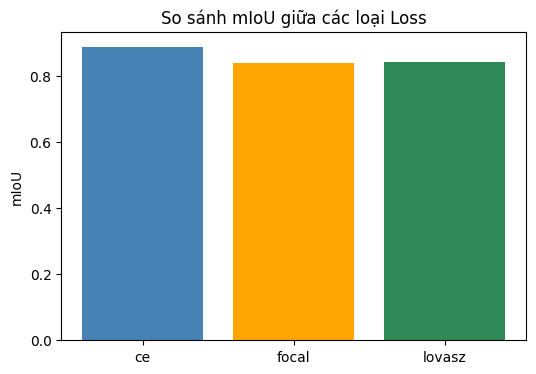

In [ ]:
import matplotlib.pyplot as plt

names = list(results.keys())
miou_values = [results[k]["mIoU"] for k in names]

plt.bar(names, miou_values, color=['steelblue', 'orange', 'seagreen'])
plt.title("So sánh mIoU giữa các loại Loss")
plt.ylabel("mIoU")
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

# -------------------------
# SimpleFPNv2 (bilinear + BN + P6,P7)
# -------------------------
class SimpleFPNv2(nn.Module):
    def __init__(self, c3, c4, c5, out=128):
        super().__init__()
        # lateral 1x1
        self.l5 = nn.Conv2d(c5, out, 1)
        self.l4 = nn.Conv2d(c4, out, 1)
        self.l3 = nn.Conv2d(c3, out, 1)
        # smooth 3x3 + BN + ReLU
        self.s5 = nn.Sequential(nn.Conv2d(out, out, 3, padding=1), nn.BatchNorm2d(out), nn.ReLU(inplace=True))
        self.s4 = nn.Sequential(nn.Conv2d(out, out, 3, padding=1), nn.BatchNorm2d(out), nn.ReLU(inplace=True))
        self.s3 = nn.Sequential(nn.Conv2d(out, out, 3, padding=1), nn.BatchNorm2d(out), nn.ReLU(inplace=True))
        # extra pyramid levels (from P5)
        self.p6 = nn.Sequential(nn.Conv2d(out, out, 3, stride=2, padding=1), nn.BatchNorm2d(out), nn.ReLU(inplace=True))
        self.p7 = nn.Sequential(nn.Conv2d(out, out, 3, stride=2, padding=1), nn.BatchNorm2d(out), nn.ReLU(inplace=True))

    def forward(self, C3, C4, C5):
        P5 = self.l5(C5)                                     # top
        P4 = self.l4(C4) + F.interpolate(P5, size=C4.shape[-2:], mode='bilinear', align_corners=False)
        P3 = self.l3(C3) + F.interpolate(P4, size=C3.shape[-2:], mode='bilinear', align_corners=False)
        # smoothing
        P3, P4, P5 = self.s3(P3), self.s4(P4), self.s5(P5)
        # extra levels
        P6 = self.p6(P5)
        P7 = self.p7(P6)
        return P3, P4, P5, P6, P7

# -------------------------
# Backbone extractor: lấy C3,C4,C5 từ ResNet
# -------------------------
class C345(nn.Module):
    def __init__(self, resnet_model):
        super().__init__()
        # stem: conv1, bn1, relu, maxpool
        self.stem = nn.Sequential(resnet_model.conv1, resnet_model.bn1, resnet_model.relu, resnet_model.maxpool)
        # layer1..layer4 of resnet
        self.l2 = resnet_model.layer1
        self.l3 = resnet_model.layer2
        self.l4 = resnet_model.layer3
        self.l5 = resnet_model.layer4

    def forward(self, x):
        x = self.stem(x)
        C2 = self.l2(x)
        C3 = self.l3(C2)
        C4 = self.l4(C3)
        C5 = self.l5(C4)
        return C3, C4, C5

# -------------------------
# FPN -> Segmentation head
# -------------------------
class FPN_SegHead(nn.Module):
    def __init__(self, backbone_model, out_channels=96, n_classes=3, freeze_backbone=True):
        """
        backbone_model: e.g. torchvision.models.resnet18(weights='DEFAULT')
        out_channels: output channels from FPN (P3..P7)
        n_classes: number of segmentation classes
        freeze_backbone: nếu True chỉ train head
        """
        super().__init__()
        # extractor (C3,C4,C5)
        self.extractor = C345(backbone_model)
        if freeze_backbone:
            for p in self.extractor.parameters():
                p.requires_grad = False

        # fpn
        # infer number of channels from backbone conv outputs if provided, else assume standard resnet18 (128,256,512)
        # here we assume backbone is ResNet-like
        self.fpn = SimpleFPNv2(c3=128, c4=256, c5=512, out=out_channels)

        # small conv head to fuse fused P3 features -> produce logits per class
        # We'll upsample fused feature to input size at the end
        self.head = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, n_classes, 1)
        )

    def forward(self, x):
        orig_size = x.shape[-2:]  # (H, W)
        C3, C4, C5 = self.extractor(x)
        P3, P4, P5, P6, P7 = self.fpn(C3, C4, C5)

        # Upsample all pyramid maps to P3 resolution and fuse
        P4u = F.interpolate(P4, size=P3.shape[-2:], mode='bilinear', align_corners=False)
        P5u = F.interpolate(P5, size=P3.shape[-2:], mode='bilinear', align_corners=False)
        P6u = F.interpolate(P6, size=P3.shape[-2:], mode='bilinear', align_corners=False)
        P7u = F.interpolate(P7, size=P3.shape[-2:], mode='bilinear', align_corners=False)

        fused = (P3 + P4u + P5u + P6u + P7u) / 5.0  # simple average fusion

        out = self.head(fused)                       # [B, n_classes, H_p3, W_p3]
        # upsample to original image size
        out = F.interpolate(out, size=orig_size, mode='bilinear', align_corners=False)
        return out

# -------------------------
# Ví dụ: khởi tạo, train nhanh 2 epoch (nhớ đặt device)
# -------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load pretrained resnet18
backbone = torchvision.models.resnet18(weights='DEFAULT')
model = FPN_SegHead(backbone_model=backbone, out_channels=96, n_classes=n_classes, freeze_backbone=True).to(device)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# quick training loop (2 epochs)
for epoch in range(2):
    model.train()
    total_loss = 0.0
    for imgs, masks in tqdm(train_loader):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        out = model(imgs)                  # out: [B, n_classes, H, W] (H,W == input size, e.g., 128)
        loss = criterion(out, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: loss={total_loss/len(train_loader):.4f}")

# -------------------------
# Hàm evaluate (mIoU) và visualize
# -------------------------
def compute_miou_for_model(model, loader, n_classes=3):
    model.eval()
    total_iou = 0.0
    count = 0
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            out = model(imgs)
            preds = torch.argmax(out, dim=1)
            for cls in range(n_classes):
                pred_inds = (preds == cls)
                target_inds = (masks == cls)
                inter = (pred_inds & target_inds).sum().item()
                union = (pred_inds | target_inds).sum().item()
                if union == 0:
                    continue
                total_iou += inter / union
                count += 1
    return (total_iou / count) if count>0 else 0.0

# visualize some predictions
def visualize_predictions(model, loader, n=4):
    model.eval()
    imgs, masks = next(iter(loader))
    imgs_cpu = imgs.clone()
    imgs, masks = imgs.to(device), masks.to(device)
    with torch.no_grad():
        out = model(imgs)
        preds = torch.argmax(out, dim=1).cpu()
    import matplotlib.pyplot as plt
    for i in range(min(n, imgs.shape[0])):
        plt.figure(figsize=(9,3))
        plt.subplot(1,3,1)
        plt.imshow(np.clip(imgs_cpu[i].permute(1,2,0).numpy(), 0, 1))
        plt.axis('off'); plt.title('Image')
        plt.subplot(1,3,2)
        plt.imshow(masks[i].cpu(), cmap='gray')
        plt.axis('off'); plt.title('GT')
        plt.subplot(1,3,3)
        plt.imshow(preds[i], cmap='gray')
        plt.axis('off'); plt.title('Pred')
        plt.show()


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 1: loss=0.3582


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 2: loss=0.1940


Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s]


Epoch 1: loss = 1.1582


Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]


Epoch 2: loss = 1.1291


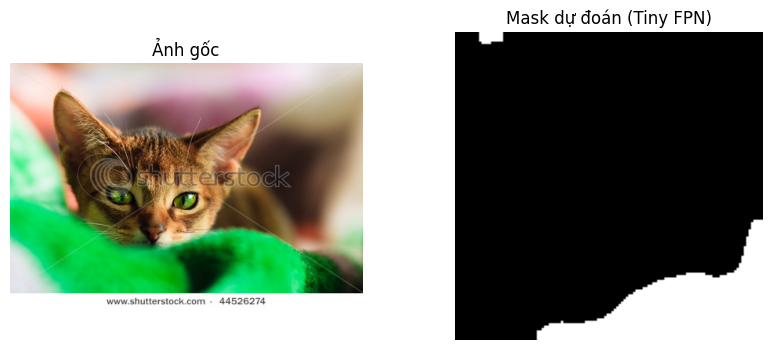

In [ ]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm


class SimpleFPN(nn.Module):
    def __init__(self, c3, c4, c5, out=128):
        super().__init__()
        self.l5 = nn.Conv2d(c5, out, 1)
        self.l4 = nn.Conv2d(c4, out, 1)
        self.l3 = nn.Conv2d(c3, out, 1)
        self.s5 = nn.Sequential(nn.Conv2d(out, out, 3, padding=1), nn.BatchNorm2d(out), nn.ReLU(inplace=True))
        self.s4 = nn.Sequential(nn.Conv2d(out, out, 3, padding=1), nn.BatchNorm2d(out), nn.ReLU(inplace=True))
        self.s3 = nn.Sequential(nn.Conv2d(out, out, 3, padding=1), nn.BatchNorm2d(out), nn.ReLU(inplace=True))
        # Extra levels
        self.p6 = nn.Conv2d(out, out, 3, stride=2, padding=1)
        self.p7 = nn.Conv2d(out, out, 3, stride=2, padding=1)

    def forward(self, C3, C4, C5):
        # Top-down FPN with bilinear interpolation
        P5 = self.l5(C5)
        P4 = self.l4(C4) + F.interpolate(P5, size=C4.shape[-2:], mode='bilinear', align_corners=False)
        P3 = self.l3(C3) + F.interpolate(P4, size=C3.shape[-2:], mode='bilinear', align_corners=False)
        P3, P4, P5 = self.s3(P3), self.s4(P4), self.s5(P5)
        P6 = self.p6(P5)
        P7 = self.p7(F.relu(P6))
        return P3, P4, P5, P6, P7


class C345(nn.Module):
    def __init__(self, m):
        super().__init__()
        self.stem = nn.Sequential(m.conv1, m.bn1, m.relu, m.maxpool)
        self.l2 = m.layer1
        self.l3 = m.layer2
        self.l4 = m.layer3
        self.l5 = m.layer4
    def forward(self, x):
        x = self.stem(x)
        C2 = self.l2(x)
        C3 = self.l3(C2)
        C4 = self.l4(C3)
        C5 = self.l5(C4)
        return C3, C4, C5


class TinyFPNNet(nn.Module):
    def __init__(self, n_classes=3, out_channels=128):
        super().__init__()
        backbone = torchvision.models.resnet18(weights='DEFAULT')
        self.extractor = C345(backbone)
        self.fpn = SimpleFPN(128, 256, 512, out=out_channels)
        # Fuse multi-level features
        self.head = nn.Sequential(
            nn.Conv2d(out_channels*3, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, n_classes, 1)
        )

    def forward(self, x):
        H, W = x.shape[-2:]
        C3, C4, C5 = self.extractor(x)
        P3, P4, P5, P6, P7 = self.fpn(C3, C4, C5)
        # Upsample to same size as P3
        P4_up = F.interpolate(P4, size=P3.shape[-2:], mode='bilinear', align_corners=False)
        P5_up = F.interpolate(P5, size=P3.shape[-2:], mode='bilinear', align_corners=False)
        feat = torch.cat([P3, P4_up, P5_up], dim=1)
        logits = self.head(feat)
        logits = F.interpolate(logits, size=(H, W), mode='bilinear', align_corners=False)
        return logits


if __name__ == "__main__":
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    n_classes = 3
    model = TinyFPNNet(n_classes=n_classes, out_channels=64).to(device)

    # --------- Giả lập dữ liệu toy để test huấn luyện ----------
    X = torch.randn(16, 3, 128, 128)
    y = torch.randint(0, n_classes, (16, 128, 128))
    loader = DataLoader(TensorDataset(X, y), batch_size=4, shuffle=True)

    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(2):
        model.train()
        total = 0
        for imgs, masks in tqdm(loader, desc=f"Epoch {epoch+1}"):
            imgs, masks = imgs.to(device), masks.to(device)
            opt.zero_grad()
            out = model(imgs)
            loss = loss_fn(out, masks)
            loss.backward()
            opt.step()
            total += loss.item()
        print(f"Epoch {epoch+1}: loss = {total/len(loader):.4f}")

    # --------- Chạy dự đoán ảnh thật ----------
    model.eval()
    img_path = "/content/data/pets/oxford-iiit-pet/images/Abyssinian_101.jpg"
    img = Image.open(img_path).convert("RGB")

    transform = T.Compose([
        T.Resize((128,128)),
        T.ToTensor(),
    ])
    inp = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(inp).argmax(1).squeeze().cpu()

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Ảnh gốc"); plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(pred, cmap='gray')
    plt.title("Mask dự đoán (Tiny FPN)"); plt.axis("off")
    plt.show()

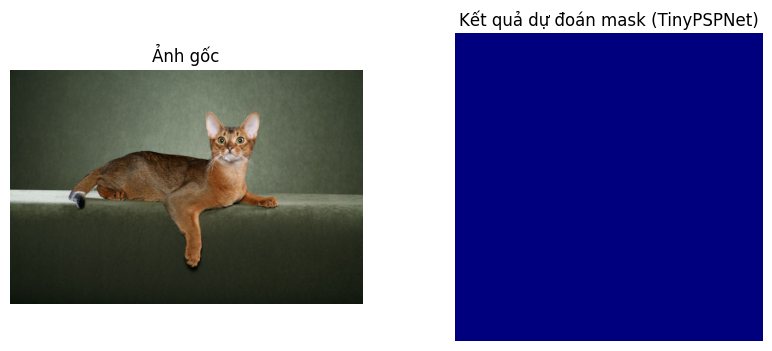

In [ ]:
# ====================== Tiny-PSPNet ======================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# ---------- Conv Block ----------
class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, s=1, p=1):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, k, stride=s, padding=p, bias=False)
        self.bn = nn.BatchNorm2d(out_ch)
        self.act = nn.ReLU(inplace=True)
    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

# ---------- Tiny Backbone ----------
class TinyBackbone(nn.Module):
    def __init__(self, base=32):
        super().__init__()
        self.stem = nn.Sequential(
            ConvBNReLU(3, base),
            ConvBNReLU(base, base)
        )
        self.down1 = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBNReLU(base, base*2),
            ConvBNReLU(base*2, base*2)
        )
        self.down2 = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBNReLU(base*2, base*4),
            ConvBNReLU(base*4, base*4)
        )

    def forward(self, x):
        x = self.stem(x)   # [B, base, H, W]
        x = self.down1(x)  # [B, 2B, H/2, W/2]
        x = self.down2(x)  # [B, 4B, H/4, W/4]
        return x

# ---------- Pyramid Pooling Module ----------
class PPM(nn.Module):
    def __init__(self, in_ch, out_ch, bins=(1,2,3,6)):
        super().__init__()
        self.bins = bins
        self.stages = nn.ModuleList([
            nn.Sequential(
                nn.AdaptiveAvgPool2d(b),
                ConvBNReLU(in_ch, out_ch, k=1, s=1, p=0)
            ) for b in bins
        ])
        self.project = ConvBNReLU(in_ch + len(bins)*out_ch, out_ch, k=3, p=1)

    def forward(self, x):
        H, W = x.shape[-2:]
        pyramids = [x]
        for stage in self.stages:
            y = stage(x)
            y = F.interpolate(y, size=(H, W), mode='bilinear', align_corners=False)
            pyramids.append(y)
        out = torch.cat(pyramids, dim=1)
        return self.project(out)

# ---------- PSPNet ----------
class TinyPSPNet(nn.Module):
    def __init__(self, n_classes=2, base=32):
        super().__init__()
        self.backbone = TinyBackbone(base=base)
        self.ppm = PPM(in_ch=base*4, out_ch=base*2, bins=(1,2,3,6))
        self.cls_head = nn.Conv2d(base*2, n_classes, 1)

    def forward(self, x):
        H, W = x.shape[-2:]
        f = self.backbone(x)      # [B, 4B, H/4, W/4]
        p = self.ppm(f)           # [B, 2B, H/4, W/4]
        logits = self.cls_head(p) # [B, C, H/4, W/4]
        logits = F.interpolate(logits, size=(H, W), mode='bilinear', align_corners=False)
        return logits

# ====================== Ví dụ dự đoán ======================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TinyPSPNet(n_classes=2, base=32).to(device)
model.eval()

# Ảnh ví dụ
image_path = "/content/data/pets/oxford-iiit-pet/images/Abyssinian_1.jpg"
img = Image.open(image_path).convert('RGB')

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

x = transform(img).unsqueeze(0).to(device)
with torch.no_grad():
    pred = model(x)
pred_mask = pred.argmax(1).squeeze().cpu().numpy()

# Hiển thị kết quả
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Ảnh gốc")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(pred_mask, cmap='jet')
plt.title("Kết quả dự đoán mask (TinyPSPNet)")
plt.axis("off")
plt.show()

# ====================== Huấn luyện (ví dụ tối giản) ======================
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# for epoch in range(num_epochs):
#     for imgs, masks in dataloader:
#         imgs, masks = imgs.to(device), masks.to(device)
#         preds = model(imgs)
#         loss = loss_fn(preds, masks)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#     print(f"Epoch {epoch+1}, Loss={loss.item():.4f}")


Feature map shape (C3): torch.Size([1, 128, 32, 32])
RoIAlign output: torch.Size([2, 128, 7, 7])


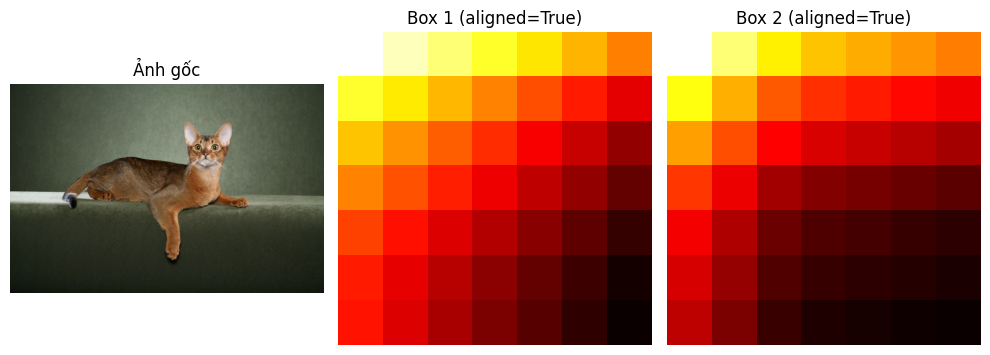

In [ ]:
# ====================== RoI Align Visualization ======================
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.ops import roi_align
from torchvision import models, transforms
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -------------------- Feature Extractor --------------------
# Dùng backbone đơn giản (ResNet18) để trích đặc trưng C3
backbone = models.resnet18(weights='IMAGENET1K_V1').to(device).eval()

# Lấy đặc trưng trung gian (ví dụ C3 = layer2 output)
extractor = nn.Sequential(*list(backbone.children())[:6]).to(device)  # conv1..layer2
stride = 8  # stride tổng cộng tới layer2 của ResNet18

# -------------------- Load ảnh mẫu --------------------
img_path = "/content/data/pets/oxford-iiit-pet/images/Abyssinian_1.jpg"
img = Image.open(img_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
x = transform(img).unsqueeze(0).to(device)

# -------------------- Forward backbone --------------------
with torch.no_grad():
    C3 = extractor(x)  # [1, C, H/8, W/8]

print("Feature map shape (C3):", C3.shape)

# -------------------- Tạo boxes giả lập --------------------
H, W = x.shape[-2:]
boxes_img = torch.tensor([
    [50, 60, 160, 200],
    [120, 80, 220, 220]
], dtype=torch.float32, device=device)

# scale to feature map coordinates
boxes_with_idx = torch.cat([
    torch.zeros((boxes_img.size(0), 1), device=device),
    boxes_img / stride
], dim=1)  # [K,5] (batch_idx, x1,y1,x2,y2)

# -------------------- RoI Align thử nghiệm --------------------
output_size = (7, 7)
aligned_mode = True

pooled = roi_align(
    C3, boxes_with_idx,
    output_size=output_size,
    spatial_scale=1/stride,
    aligned=aligned_mode
)  # [K, C, 7,7]

print(f"RoIAlign output: {pooled.shape}")

# -------------------- Heatmap Visualization --------------------
# Lấy trung bình theo channel để dễ xem
heatmaps = pooled.mean(1).cpu().numpy()  # [K, H, W]

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Ảnh gốc")
plt.axis("off")

for i, hmap in enumerate(heatmaps):
    plt.subplot(1,3,i+2)
    plt.imshow(hmap, cmap='hot')
    plt.title(f"Box {i+1} (aligned={aligned_mode})")
    plt.axis("off")

plt.tight_layout()
plt.show()

# -------------------- Thử nghiệm khác --------------------
# Bạn có thể đổi thử:
# output_size = (3,3) hoặc (14,14)
# aligned_mode = False
# để quan sát sự khác biệt về vùng và độ mượt của đặc trưng.
